In [1]:
# for using gradcam
!pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00


In [2]:
# Importing required libraries

import warnings
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

#import all necessary layers
from tensorflow.keras.layers import Input, DepthwiseConv2D
from tensorflow.keras.layers import Conv2D, BatchNormalization
from tensorflow.keras.layers import ReLU, AvgPool2D, Flatten, Dense
from tensorflow.keras import Model

from tf_explain.core.grad_cam import GradCAM

In [3]:
# Specifying our training batch size
BATCH_SIZE = 32

# Specifying the image size
IMAGE_SIZE = [224, 224]

# List containing class names, which will be used to index on our model output
# 0 = NORMAL, 1 = PNEUMONIA
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

In [6]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

In [7]:
COUNT_NORMAL = len([filename for filename in train_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

print('Total Count of images:', COUNT_NORMAL+COUNT_PNEUMONIA )

Normal images count in training set: 1349
Pneumonia images count in training set: 3883
Total Count of images: 5232


In [8]:
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT)  / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [9]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
      return tf.cast(1,dtype=tf.int8)
    else:
      return tf.cast(0,dtype=tf.int8)


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path)

In [10]:
ds = ds.shuffle(10000)
train_ds = ds.take(4300)
val_ds = ds.skip(4300)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)

Image shape:  (224, 224, 3)


In [14]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)

COUNT_NORMAL = len([filename for filename in test_paths if "NORMAL" in filename.numpy().decode("utf-8")])
print("Normal images count in test set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in test_paths if "PNEUMONIA" in filename.numpy().decode("utf-8")])
print("Pneumonia images count in test set: " + str(COUNT_PNEUMONIA))

Normal images count in test set: 234
Pneumonia images count in test set: 390


In [21]:
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path)
test_ds_batch = test_ds.batch(BATCH_SIZE)

In [ ]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.

    ds = ds.cache()
    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=BATCH_SIZE)

    return ds

In [ ]:
train_ds_batch = prepare_for_training(train_ds)
val_ds_batch = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds_batch))

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

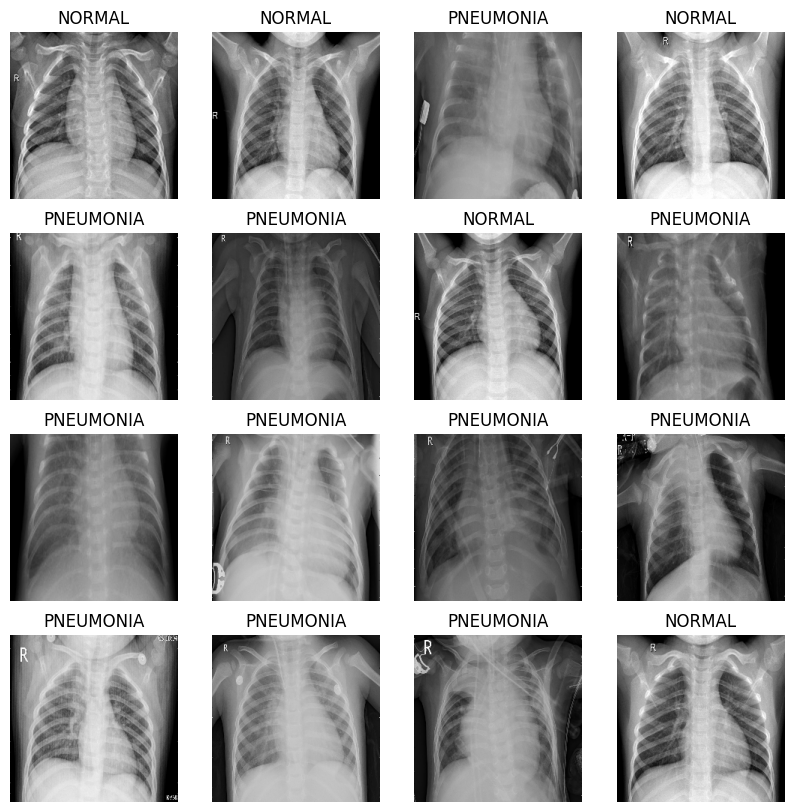

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def build_model():

    mobilenet_model = tf.keras.applications.MobileNetV2(
        weights ='imagenet',
        include_top = False,
        input_shape = (224,224,3)
    )

    #Freezing the pretrained mobilenet layers except the last  layer
    # Known as finetuning the model

    for layer in mobilenet_model.layers[:-2]:
        layer.trainable = False


    #Output of base model
    x = mobilenet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation = "relu")(x)
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    pretrained_model = tf.keras.Model(inputs = mobilenet_model.input, outputs = output)

    return pretrained_model

In [ ]:
finetuned_mobilenet = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Visualizing our model layers and parameters
finetuned_mobilenet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 166,657 (651.00 KB)

 Non-trainable params: 2,255,424 (8.60 MB)

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive/',force_remount=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

# initial_learning_rate = 0.01, scaling factor = 20
exponential_decay_fn = exponential_decay(0.01, 20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
def model_training(class_weights,model_name,patience=3,epochs=10):

  checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filepath = model_name+".keras", save_best_only=True)
  early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)

  METRICS = [
  tf.keras.metrics.BinaryAccuracy(),
  tf.keras.metrics.Precision(name="precision"),
  tf.keras.metrics.Recall(name="recall"),
  ]

  finetuned_mobilenet.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss="binary_crossentropy",
  metrics=METRICS,
  )

  history = finetuned_mobilenet.fit(
  train_ds_batch,
  epochs = epochs,
  validation_data = val_ds_batch,
  class_weight = class_weight,
  callbacks=[checkpoint_cb,early_stopping_cb,lr_scheduler]
  )
  return history

def plotting(history):
  fig, ax = plt.subplots(1, 4, figsize=(20, 3))
  ax = ax.ravel()

  for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

def eval_on_test_data(model_name):
  loaded_mobilenet = tf.keras.models.load_model(model_name+".keras")
  print(loaded_mobilenet.evaluate(test_ds_batch, return_dict=True))

def eval_on_test_image():
  for image, label in test_ds_batch.take(1):
      plt.imshow(image[2] / 255.0)
      plt.title(CLASS_NAMES[label[2].numpy()])
      plt.axis('off')
  prediction = finetuned_mobilenet.predict(test_ds_batch.take(1))[2]
  scores = [1 - prediction, prediction]
  for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))
  %time

def prediction_on_test_data():
  label_list = []
  prediction_list = []

  for image, label in test_ds:
    image = tf.expand_dims(image, axis = 0)
    prediction = finetuned_mobilenet.predict(image,verbose=0)

    if prediction > 0.5 :
      prediction = 1
    else :
      prediction = 0

    prediction_list.append(prediction)
    label_list.append(label)
  return label_list,prediction_list

def plot_confusion_matrix_on_test_data():
  label_list,prediction_list = prediction_on_test_data()
  test_confusion_matrix = tf.math.confusion_matrix(label_list, prediction_list)
  ax = sns.heatmap(test_confusion_matrix, annot = True, fmt ='g')
  ax.set(xlabel = 'Predicted values', ylabel = 'Actual values')
  plt.show()

In [ ]:
print(class_weight)

{0: 1.939214232765011, 1: 0.6737058975019315}


In [ ]:
history = model_training(class_weights = class_weight,model_name = "xray_model", patience = 3,epochs = 10)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - binary_accuracy: 0.9106 - loss: 0.2347 - precision: 0.9664 - recall: 0.9114 - val_binary_accuracy: 0.7843 - val_loss: 0.4404 - val_precision: 0.7734 - val_recall: 1.0000 - learning_rate: 0.0100
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - binary_accuracy: 0.9414 - loss: 0.1362 - precision: 0.9830 - recall: 0.9372 - val_binary_accuracy: 0.7715 - val_loss: 0.5341 - val_precision: 0.7631 - val_recall: 1.0000 - learning_rate: 0.0089
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - binary_accuracy: 0.9512 - loss: 0.1515 - precision: 0.9826 - recall: 0.9511 - val_binary_accuracy: 0.8047 - val_loss: 0.4547 - val_precision: 0.7910 - val_recall: 0.9985 - learning_rate: 0.0079
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - binary_accuracy: 0.9637 - loss: 0.0891 - precision: 0.9888 - recall: 0.9620 - val_binary_accuracy: 0.8294 - val_loss: 0.3863 - val_precision: 0.8126 - val_recall: 0.9985 - learning_rate: 0.0071
E

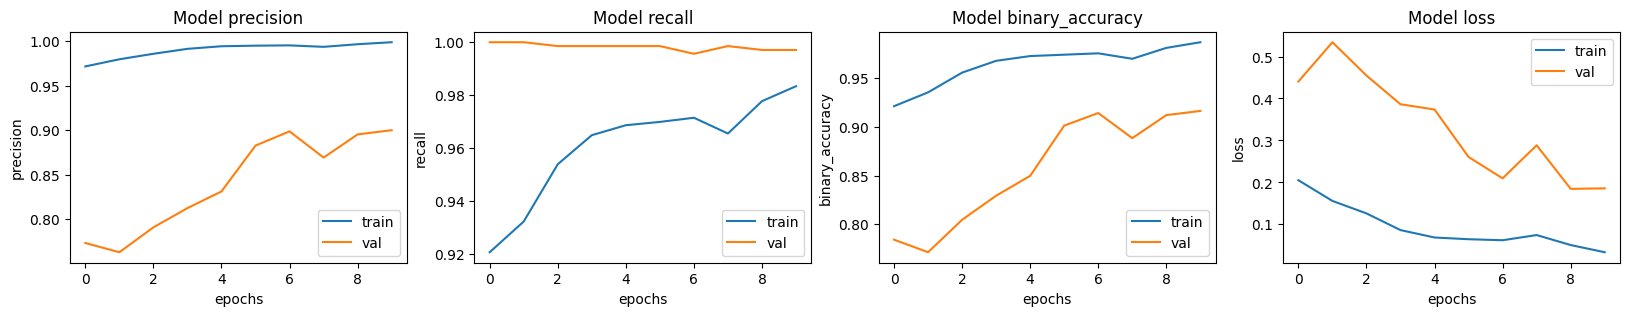

In [ ]:
plotting(history)

In [ ]:
eval_on_test_data("xray_model")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - binary_accuracy: 0.3996 - loss: 2.3738 - precision: 0.3186 - recall: 0.6636
{'binary_accuracy': 0.6714743375778198, 'loss': 1.3066452741622925, 'precision': 0.6565144062042236, 'recall': 0.9948717951774597}


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image is 15.46 percent NORMAL
This image is 84.54 percent PNEUMONIA
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs


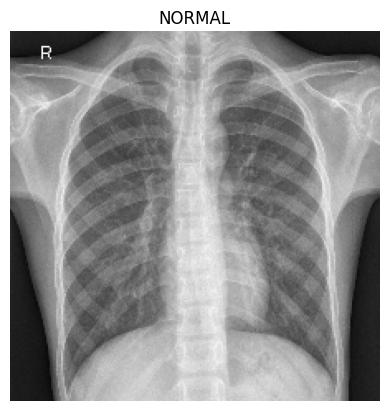

In [ ]:
eval_on_test_image()

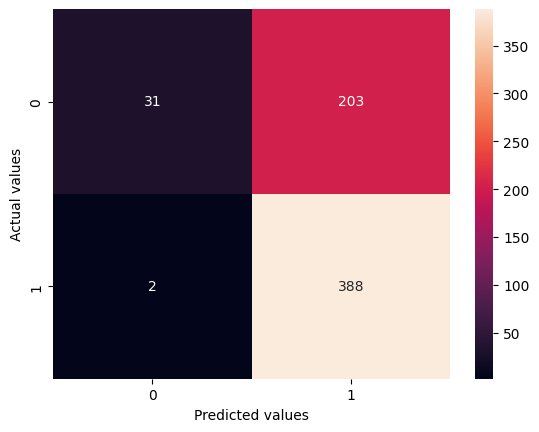

In [ ]:
plot_confusion_matrix_on_test_data()

In [ ]:
class_weight = {0:2.6,1:0.2}

In [ ]:
history = model_training(class_weights = class_weight,model_name = "xray_model1", patience = 3,epochs = 10)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - binary_accuracy: 0.9407 - loss: 0.0736 - precision: 0.9933 - recall: 0.9263 - val_binary_accuracy: 0.9217 - val_loss: 0.3853 - val_precision: 0.9968 - val_recall: 0.8965 - learning_rate: 0.0100
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - binary_accuracy: 0.9359 - loss: 0.0948 - precision: 0.9934 - recall: 0.9197 - val_binary_accuracy: 0.9721 - val_loss: 0.0829 - val_precision: 0.9714 - val_recall: 0.9913 - learning_rate: 0.0089
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - binary_accuracy: 0.9688 - loss: 0.0248 - precision: 0.9988 - recall: 0.9591 - val_binary_accuracy: 0.9732 - val_loss: 0.0814 - val_precision: 0.9715 - val_recall: 0.9927 - learning_rate: 0.0079
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - binary_accuracy: 0.9673 - loss: 0.0258 - precision: 0.9990 - recall: 0.9569 - val_binary_accuracy: 0.9710 - val_loss: 0.0767 - val_precision: 0.9700 - val_recall: 0.9913 - learning_rate: 0.0071
E

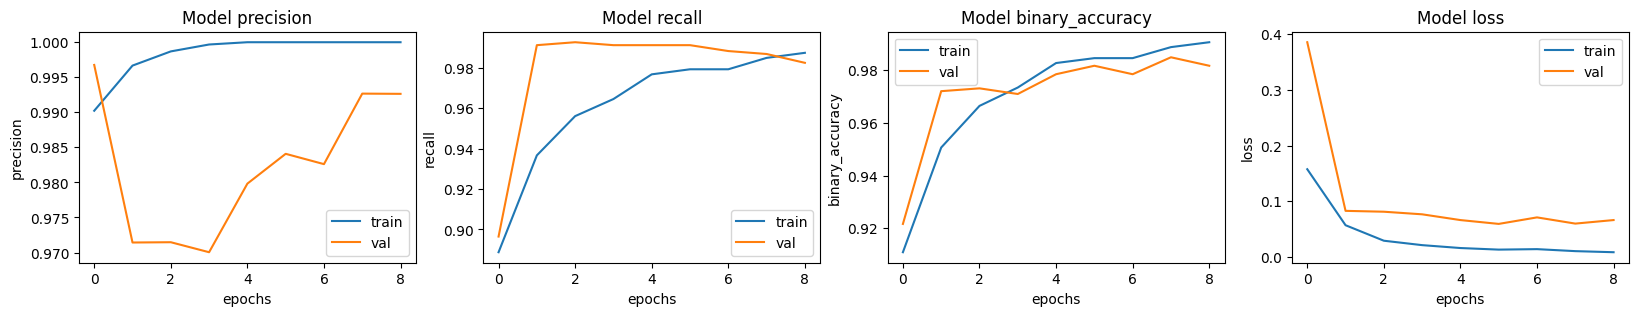

In [ ]:
plotting(history)

In [ ]:
eval_on_test_data("xray_model1")

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - binary_accuracy: 0.5855 - loss: 2.0817 - precision: 0.3666 - recall: 0.6593
{'binary_accuracy': 0.7596153616905212, 'loss': 1.2001651525497437, 'precision': 0.7264150977134705, 'recall': 0.9871794581413269}


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image is 80.70 percent NORMAL
This image is 19.30 percent PNEUMONIA
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


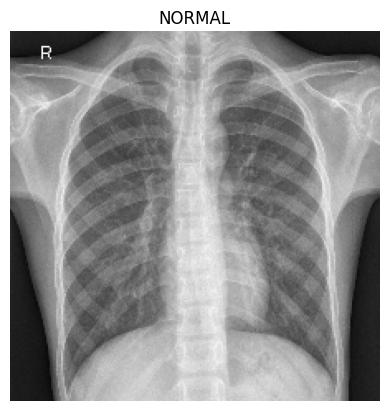

In [ ]:
eval_on_test_image()

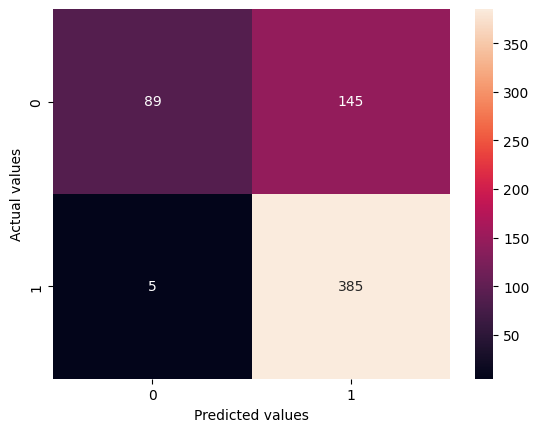

In [ ]:
plot_confusion_matrix_on_test_data()

In [ ]:
class_weight = {0:3,1:0.2}

In [ ]:
history = model_training(class_weights = class_weight,model_name = "xray_model2", patience = 4,epochs = 10)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 23s 107ms/step - binary_accuracy: 0.9695 - loss: 0.0348 - precision: 0.9967 - recall: 0.9621 - val_binary_accuracy: 0.9753 - val_loss: 0.0913 - val_precision: 0.9926 - val_recall: 0.9738 - learning_rate: 0.0100
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - binary_accuracy: 0.9824 - loss: 0.0150 - precision: 0.9990 - recall: 0.9772 - val_binary_accuracy: 0.9807 - val_loss: 0.0927 - val_precision: 0.9955 - val_recall: 0.9781 - learning_rate: 0.0089
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - binary_accuracy: 0.9888 - loss: 0.0097 - precision: 1.0000 - recall: 0.9849 - val_binary_accuracy: 0.9710 - val_loss: 0.1511 - val_precision: 0.9985 - val_recall: 0.9621 - learning_rate: 0.0079
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - binary_accuracy: 0.9875 - loss: 0.0104 - precision: 0.9994 - recall: 0.9838 - val_binary_accuracy: 0.9624 - val_loss: 0.2021 - val_precision: 1.0000 - val_recall: 0.9490 - learning_rate: 0.0071
E

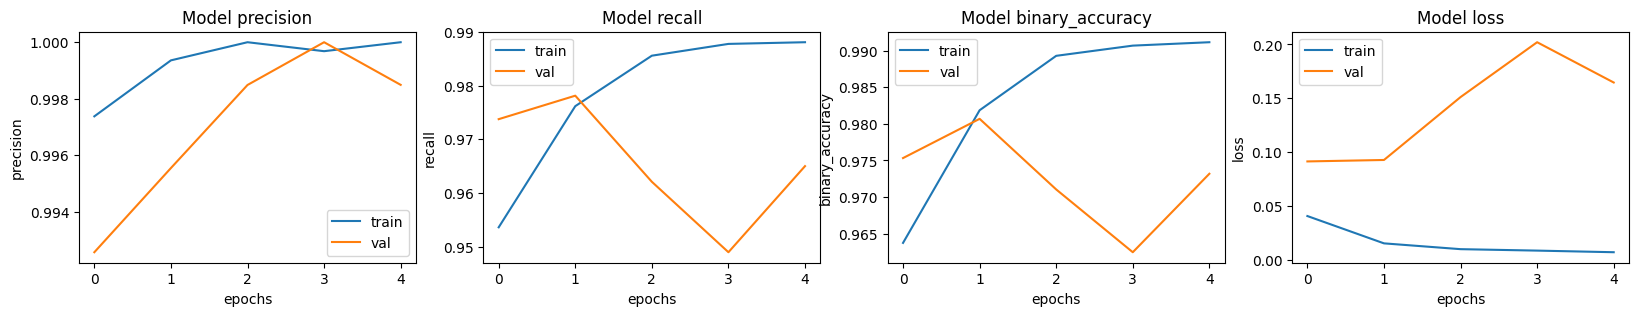

In [ ]:
plotting(history)

In [ ]:
eval_on_test_data("xray_model2")

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - binary_accuracy: 0.6895 - loss: 1.4849 - precision: 0.4026 - recall: 0.6513
{'binary_accuracy': 0.8044871687889099, 'loss': 0.9136282205581665, 'precision': 0.7734693884849548, 'recall': 0.971794843673706}


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image is 99.36 percent NORMAL
This image is 0.64 percent PNEUMONIA
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


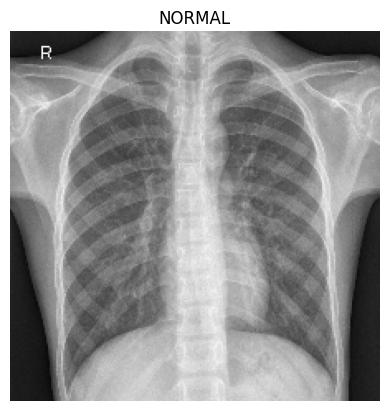

In [ ]:
eval_on_test_image()

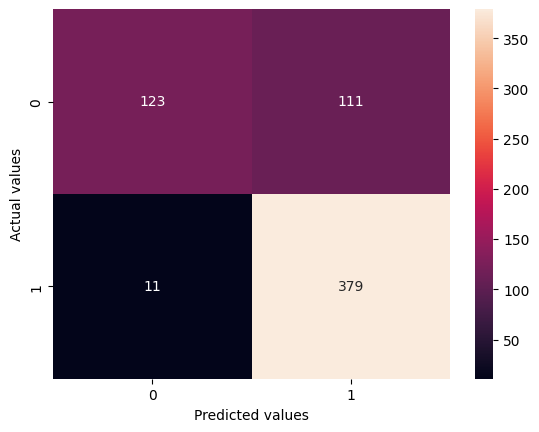

In [ ]:
plot_confusion_matrix_on_test_data()

In [ ]:
last_conv_layer_name = None

for i in range(len(finetuned_mobilenet.layers)):
    layer = finetuned_mobilenet.layers[i]
    if 'conv' in layer.name.lower():  # Check for 'conv' in layer name
        print(i, layer.name, layer.output.shape)
        last_conv_layer_name = layer.name  # Update to the latest convolutional layer name

# Confirm the selected last convolutional layer
print("\nLast Convolutional Layer:", last_conv_layer_name)


1 Conv1 (None, 112, 112, 32)
2 bn_Conv1 (None, 112, 112, 32)
3 Conv1_relu (None, 112, 112, 32)
4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)
151 Conv_1 (None, 7, 7, 1280)
152 Conv_1_bn (None, 7, 7, 1280)

Last Convolutional Layer: Conv_1_bn


Original label PNEUMONIA
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
This image is 0.00 percent NORMAL
This image is 100.00 percent PNEUMONIA


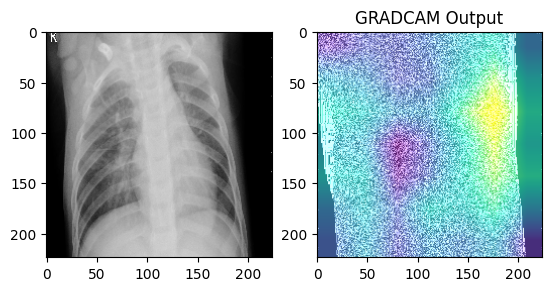

In [ ]:
for image, label in test_ds_batch.skip(14).take(1):

    data = ([image[1].numpy()], None)
    print('Original label',CLASS_NAMES[label[1].numpy()])
    image = image[1] / 255

prediction = finetuned_mobilenet.predict(test_ds_batch.skip(14).take(1))[1]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, finetuned_mobilenet,class_index = 0,layer_name=last_conv_layer_name)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)

# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()

# Deployement Purpose

In [4]:
# downloading the model that i have saved
!gdown 1bVvXCTEal4vk9VnMnxSIqCuJbxrY2F-E -O xray_model2.keras

Downloading...
From: https://drive.google.com/uc?id=1bVvXCTEal4vk9VnMnxSIqCuJbxrY2F-E
To: /content/xray_model2.keras
100% 11.6M/11.6M [00:00<00:00, 29.0MB/s]


In [54]:
!ls

sample_data  sample_images  xray_model2.keras


In [ ]:
from google.colab import files
import os

In [59]:
# saving non pneumonic images
save_dir = "sample_images/non_pneumonic"
os.makedirs(save_dir, exist_ok=True)
for i, raw_image in enumerate(test_images.take(5)):
    img_tensor = tf.image.decode_jpeg(raw_image, channels=3)

    # Save image locally
    image_path = os.path.join(save_dir, f"image_{i+1}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, img_tensor)
    print(f"Image saved: {image_path}")

In [ ]:
# saving pneumonic images
save_dir = "sample_images/pneumonic"
os.makedirs(save_dir, exist_ok=True)
for i, raw_image in enumerate(test_images.skip(303).take(5)):
    img_tensor = tf.image.decode_jpeg(raw_image, channels=3)

    # Save image locally
    image_path = os.path.join(save_dir, f"image_{i+1}.jpg")
    tf.keras.preprocessing.image.save_img(image_path, img_tensor)
    print(f"Image saved: {image_path}")

In [58]:
folder_path = "sample_images/pneumonic"

# List all files in the folder
file_name = os.listdir(folder_path)
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    files.download(file_path)  # Downloads each file separately


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# downloading images locally
folder_paths = ["sample_images/non_pneumonic","sample_images/non_pneumonic"]

# List all files in the folder
for folder_path in folder_paths:
  file_name = os.listdir(folder_path)
  for file_name in os.listdir(folder_path):
      file_path = os.path.join(folder_path, file_name)
      files.download(file_path)  # Downloads each file separately


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## For Runtime Environment

In [ ]:
import tensorflow as tf
from tf_explain.core.grad_cam import GradCAM
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

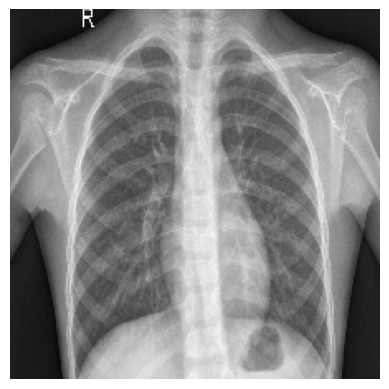

In [205]:
# Define image size
IMAGE_SIZE = [224, 224]

# Function to show image
def show_image(image):
    plt.imshow(image / 255)  # Normalize if needed
    plt.axis("off")  # Hide axes
    plt.show()

# Function to resize an image
def resize_img(img):
    return tf.image.resize(img, IMAGE_SIZE)

# Load the image
image_path = "sample_images/non_pneumonic/image_1.jpg"
image = tf.io.read_file(image_path)  # Read image as raw bytes
image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image
image = resize_img(image)  # Resize the image

# Show the resized image
show_image(image)


In [213]:
last_conv_layer_name = None

for i in range(len(loaded_mobilenet.layers)):
    layer = loaded_mobilenet.layers[i]
    if 'conv' in layer.name.lower():  # Check for 'conv' in layer name
        print(i, layer.name, layer.output.shape)
        last_conv_layer_name = layer.name  # Update to the latest convolutional layer name

# Confirm the selected last convolutional layer
print("\nLast Convolutional Layer:", last_conv_layer_name)

1 Conv1 (None, 112, 112, 32)
2 bn_Conv1 (None, 112, 112, 32)
3 Conv1_relu (None, 112, 112, 32)
4 expanded_conv_depthwise (None, 112, 112, 32)
5 expanded_conv_depthwise_BN (None, 112, 112, 32)
6 expanded_conv_depthwise_relu (None, 112, 112, 32)
7 expanded_conv_project (None, 112, 112, 16)
8 expanded_conv_project_BN (None, 112, 112, 16)
151 Conv_1 (None, 7, 7, 1280)
152 Conv_1_bn (None, 7, 7, 1280)

Last Convolutional Layer: Conv_1_bn


## Prediction

In [206]:
image_batch = tf.expand_dims(image, axis=0)

In [207]:
loaded_mobilenet = tf.keras.models.load_model("xray_model2.keras")
prediction = loaded_mobilenet.predict(image_batch)
scores = [1 - prediction, prediction]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [209]:
scores

[array([[0.9999972]], dtype=float32), array([[2.7946128e-06]], dtype=float32)]

In [210]:
for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))

This image is 100.00 percent NORMAL
This image is 0.00 percent PNEUMONIA


In [211]:
data = ([image.numpy()], None)
image = image / 255

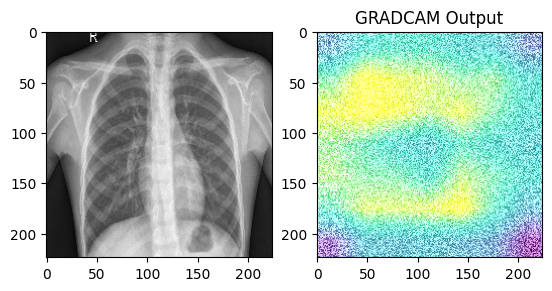

In [212]:
# Start explainer
explainer = GradCAM()
# Now use it in Grad-CAM
grid = explainer.explain(data, loaded_mobilenet, class_index=0, layer_name=last_conv_layer_name)


#grid = explainer.explain(data, loaded_mobilenet,class_index = 0,layer_name=last_conv_layer_name)

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2)

axarr[0].imshow(image)
axarr[1].imshow(grid)

# axarr[0].title.set_text(f"{float(prediction)*100:.2f}% penumonia predicted")
axarr[1].title.set_text('GRADCAM Output')
plt.show()

In [214]:
pip freeze>requirements.txt

In [216]:
files.download("requirements.txt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>